<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

#### Loading pre-trained model

In [2]:
base_model = keras.applications.InceptionV3(include_top = False, weights = "imagenet")

In [3]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [4]:
# selecting the layer we want to use for our deep dream operation, more layers we use the more time needed to gen
# interesting images
names = ["mixed3", "mixed5", "mixed8", "mixed9"]

# names = ["mixed3", "mixed5", "mixed8"]

In [5]:
layers = [base_model.get_layer(name).output for name in names]

deep_dream_model =keras.Model(inputs = base_model.input, outputs = layers)

### Loading and Preprocessing image

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


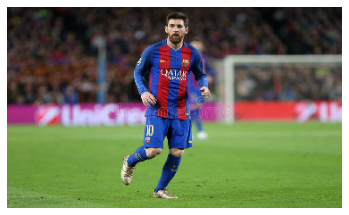

In [6]:
# image = keras.preprocessing.image.load_img("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/StaryNight.jpg",
#                                            target_size = (225, 375))

image = keras.preprocessing.image.load_img("/content/drive/MyDrive/Computer Vision Masterclass Files/Images/messi_image.jpg",
                                           target_size = (225, 375))

plt.axis("off")
plt.imshow(image);

In [7]:
type(image), image.size

(PIL.Image.Image, (375, 225))

In [8]:
# get color space
image.mode, len(image.mode)

('RGB', 3)

In [9]:
# convert image to np format needed by tf
image = keras.preprocessing.image.img_to_array(image)

image.shape, type(image)

((225, 375, 3), numpy.ndarray)

In [10]:
# scale the image using helper from our pretrained inception model
image = keras.applications.inception_v3.preprocess_input(image)

In [11]:
image.min(), image.max()

(-1.0, 1.0)

#### Getting the activations

In [12]:
# image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

image_batch = tf.expand_dims(image, axis = 0) # same as np own

activations = deep_dream_model.predict(image_batch)

1/1 [==============================] - 4s 4s/step


In [13]:
deep_dream_model.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 <KerasTensor: shape=(None, None, None, 1280) dtype=float32 (created by layer 'mixed8')>,
 <KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'mixed9')>]

In [14]:
activations[0].shape, activations[1].shape

((1, 12, 21, 768), (1, 12, 21, 768))

#### Calculating the loss

* Here it is calculated against the input image inorder to change the pixel of the images, not like normal NN loss calculations against y_true

In [15]:
def calculate_loss(image, network):
  image_batch = tf.expand_dims(image, axis = 0)

  activations = network(image_batch)

  losses = []
  for act in activations:
    loss = tf.math.reduce_mean(act)  # ret mean of values which is our activations of layer in focus
    losses.append(loss)

  # print(losses)
  return tf.reduce_sum(losses)   # sum up all activations, which will be the loss

In [16]:
loss = calculate_loss(image, deep_dream_model)

print(loss)

tf.Tensor(0.9253724, shape=(), dtype=float32)


#### Gradient Ascent(maximizes the error, and emphasizes part of input image in result)

In [24]:
# gradient with respect to image and add this to input image pixels to change it

@tf.function
def deep_dream(network, image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)   # ensures that change to this image isn't lost, most used if image is a constant and not a variable
    loss = calculate_loss(image, network)
  
  # gets dy/dx of loss wrt image
  gradients = tape.gradient(loss, image)  
  gradients /= tf.math.reduce_std(gradients)  # to get smaller gradient values and norm gradients

  image = image + gradients * learning_rate  # updating pixel of image
  image = tf.clip_by_value(image, -1, 1)     # scale image value to still be in -1, and 1

  return loss, image

In [25]:
# to get image in original format for displaying
def inverse_transform(image):
  image = 255 * (image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)

In [26]:
def run_deep_dream(network, image, epochs , learning_rate):
  for epoch in range(epochs):
    loss, image = deep_dream(network, image, learning_rate)

    if(epoch == epochs - 1):
      # show current image after 200 epochs
      plt.figure(figsize = (12, 12))
      plt.imshow(inverse_transform(image))
      plt.show();
      print(f"Epoch: {epoch}, loss: {loss}")

#### Generating Deep Dream Images

In [27]:
image.shape, type(image)

((225, 375, 3), numpy.ndarray)

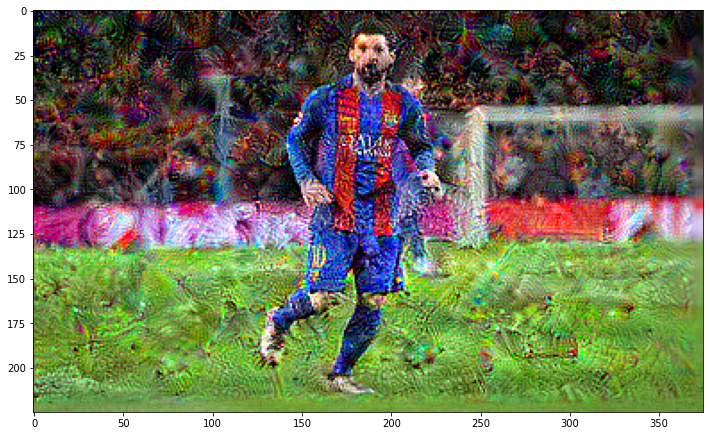

Epoch: 11999, loss: 4.335072040557861


In [29]:
run_deep_dream(network= deep_dream_model, image = image, epochs = 12000, learning_rate = 0.001)